In [19]:

# importing the requirements and uploading the data (.CSV file)
from google.colab import files
import pandas as pd
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

print("upload the CSV file:")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")

csv_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[csv_name]))
print(f"Loaded {csv_name} with shape {df.shape}")
display(df.head(3))
print("Columns:", list(df.columns))


upload the CSV file:


Saving fractional_crop_residue_gv_soil_lon_lat_photo_v5_FINAL_with_reflectance_indices.csv to fractional_crop_residue_gv_soil_lon_lat_photo_v5_FINAL_with_reflectance_indices (2).csv
Loaded fractional_crop_residue_gv_soil_lon_lat_photo_v5_FINAL_with_reflectance_indices (2).csv with shape (895, 36)


,index,fR,fGV,fSoil,year,lat_utm18n,lon_utm18n,lat_degrees,lon_degrees,photo_id,...,R_2259,R_2329,R_swir1,R_swir2,wi,ndti,swira,sindri,sidri,ndvi
0,0,0.54,0.02,0.44,5/15/2015,4300863.994,418223.8101,38.852802,-75.942429,IMG_0219.JPG,...,0.367,0.352,0.434,0.375,1.157,0.073,0.248,0.012,0.009,0.189
1,1,0.56,0.02,0.42,5/15/2015,4300855.151,418220.4211,38.852722,-75.942467,IMG_0220.JPG,...,0.374,0.358,0.440,0.382,1.154,0.071,0.248,0.015,0.011,0.190
2,2,0.59,0.02,0.39,5/15/2015,4300856.024,418221.8186,38.852730,-75.942451,IMG_0221.JPG,...,0.373,0.358,0.439,0.381,1.152,0.071,0.244,0.014,0.010,0.188


Columns: ['index', 'fR', 'fGV', 'fSoil', 'year', 'lat_utm18n', 'lon_utm18n', 'lat_degrees', 'lon_degrees', 'photo_id', 'residue_type', 'cover_crop_residue', 'R_427', 'R_482', 'R_547', 'R_604', 'R_660', 'R_723', 'R_824', 'R_914', 'R_1209', 'R_1572', 'R_1661', 'R_1730', 'R_2164', 'R_2202', 'R_2259', 'R_2329', 'R_swir1', 'R_swir2', 'wi', 'ndti', 'swira', 'sindri', 'sidri', 'ndvi']


In [20]:

# Config
FORCE_TARGET_NAME = "fR"
FEATURE_COLS = [
    "R_427", "R_482", "R_547", "R_604", "R_660", "R_723", "R_824", "R_914",
    "R_1209", "R_1572", "R_1661", "R_1730", "R_2164", "R_2202", "R_2259", "R_2329",
    "R_swir1", "R_swir2", "wi", "ndti", "swira", "sindri", "sidri", "ndvi"
]

# Train/validation/test split
TEST_SIZE = 0.2
VAL_SIZE = 0.2

# the Deep Neural Networks hyperparameters
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
OPTIMIZER = "adam"       # "adam", "sgd", "rmsprop"
HIDDEN_LAYERS = [128, 64, 32]  # neurons per hidden layer
DROPOUT = 0.1
L2_REG = 1e-4            # L2 regularization strength
PATIENCE_EARLYSTOP = 25
PATIENCE_LR = 8
RANDOM_STATE = 42


np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [21]:

# Resolving the features and target ===
# Case-insensitive mapping
col_map = {c.lower(): c for c in df.columns}

def resolve_cols(requested):
    resolved, missing = [], []
    for name in requested:
        key = name.lower()
        if key in col_map:
            resolved.append(col_map[key])
        else:
            missing.append(name)
    return resolved, missing

resolved_features, missing_features = resolve_cols(FEATURE_COLS)
print(f"Resolved {len(resolved_features)} / {len(FEATURE_COLS)} feature columns.")
if missing_features:
    print("Missing feature columns:", missing_features)

# Target
if FORCE_TARGET_NAME:
    tgt_key = FORCE_TARGET_NAME.lower()
    if tgt_key not in col_map:
        raise ValueError(f"FORCE_TARGET_NAME '{FORCE_TARGET_NAME}' not found. Columns: {list(df.columns)}")
    target_col = col_map[tgt_key]
else:
    # Fallback: try to guess anything with 'residue' in its name
    residue_like = [c for c in df.columns if "residue" in c.lower()]
    if residue_like:
        target_col = residue_like[0]
    else:
        raise ValueError("Could not find a residue target column. Set FORCE_TARGET_NAME to your numeric residue column.")

print("Using target column:", target_col)


Resolved 24 / 24 feature columns.
Using target column: fR


In [22]:

# Preparing X, y and clean
X = df[resolved_features].copy()
y = pd.to_numeric(df[target_col], errors="coerce")

# making sure that there is numeric features
X = X.apply(pd.to_numeric, errors="coerce")

# Diagnostics
print("NaN counts per feature:")
display(X.isna().sum())

mask = X.notna().all(axis=1) & y.notna()
valid_rows = int(mask.sum())
print(f"Valid rows after cleaning: {valid_rows}")
if valid_rows == 0:
    raise ValueError("After cleaning, 0 valid samples. Check column names and numeric target (e.g., 'fR').")

X = X[mask].to_numpy(dtype=np.float32)
y = y[mask].to_numpy(dtype=np.float32)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Scale features which is crucial for DNNs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building validation split from the training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_val.shape, X_test.shape


NaN counts per feature:


,0
R_427,0
R_482,0
R_547,0
R_604,0
R_660,0
R_723,0
R_824,0
R_914,0
R_1209,0
R_1572,0


Valid rows after cleaning: 895


((572, 24), (144, 24), (179, 24))


## Building the Deep Neural Network

- Fully connected (dense) regression network  
- Activation functions are  ReLU  
- Regularizations are Dropout + L2  
- Optimizer **with explicit learning rate** (Adam/SGD/RMSprop)  
- EarlyStopping and ReduceLROnPlateau callbacks


In [23]:

# Building the model model
def build_regression_mlp(input_dim, layers_list, dropout=0.0, l2_reg=0.0):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for units in layers_list:
        x = layers.Dense(units, activation="relu",
                         kernel_regularizer=regularizers.l2(l2_reg))(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs, name="ResidueC")

input_dim = X_train.shape[1]
model = build_regression_mlp(input_dim, HIDDEN_LAYERS, DROPOUT, L2_REG)

# Choose optimizer with explicit LR
opt = None
if OPTIMIZER.lower() == "adam":
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
elif OPTIMIZER.lower() == "sgd":
    opt = keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True)
elif OPTIMIZER.lower() == "rmsprop":
    opt = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
else:
    raise ValueError("Unsupported OPTIMIZER. Choose from: 'adam', 'sgd', 'rmsprop'.")

model.compile(optimizer=opt, loss="mse", metrics=[keras.metrics.MeanAbsoluteError(name="mae")])
model.summary()


Model: "ResidueC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:

# Training
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE_EARLYSTOP,
                                      restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                              patience=PATIENCE_LR, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early, reduce_lr],
    verbose=1
)


Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1865 - mae: 0.3334 - val_loss: 0.0879 - val_mae: 0.2212 - learning_rate: 0.0010
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0859 - mae: 0.2156 - val_loss: 0.0578 - val_mae: 0.1552 - learning_rate: 0.0010
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0706 - mae: 0.1861 - val_loss: 0.0479 - val_mae: 0.1372 - learning_rate: 0.0010
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0630 - mae: 0.1732 - val_loss: 0.0473 - val_mae: 0.1348 - learning_rate: 0.0010
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0622 - mae: 0.1654 - val_loss: 0.0433 - val_mae: 0.1290 - learning_rate: 0.0010
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0534 - mae: 0.1560 - val_loss: 0.0403 - val_mae: 0.1219 - learning_rate: 0.0010
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0537 - mae: 0.1550 - val_loss: 0.0423 - val_mae: 0.1266 - learning_rate: 0.0010
Epoch 8/300
9/9 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test R²:  0.8951
Test RMSE:0.1011
Test MAE: 0.0813


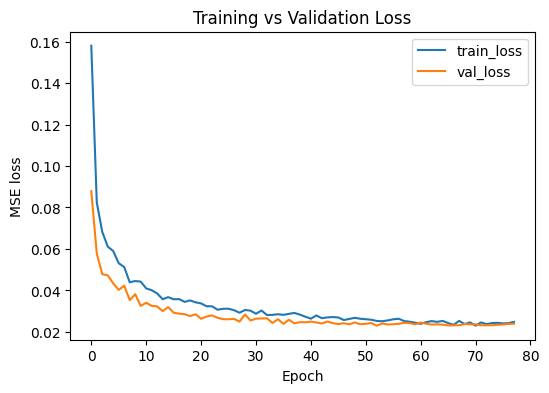

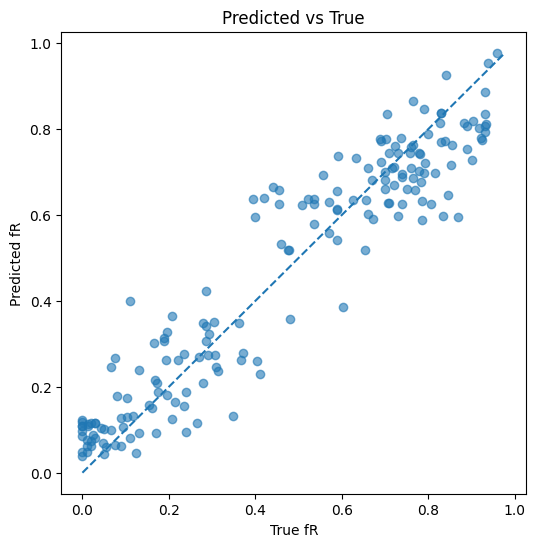

In [25]:

# Evaluateing and the plots
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

preds_test = model.predict(X_test).reshape(-1,)
r2 = r2_score(y_test, preds_test)
mae = mean_absolute_error(y_test, preds_test)
rmse_val = rmse(y_test, preds_test)
print(f"Test R²:  {r2:.4f}")
print(f"Test RMSE:{rmse_val:.4f}")
print(f"Test MAE: {mae:.4f}")

# the Loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds_test, alpha=0.6)
lims = [min(y_test.min(), preds_test.min()), max(y_test.max(), preds_test.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True fR")
plt.ylabel("Predicted fR")
plt.title("Predicted vs True")
plt.show()
